In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
tf.__version__

'2.16.1'

In [31]:
# Sampling
n_interior = 1000
n_boundary = 500
xlow, xhigh = 0, np.pi 
tlow, thigh = 0, np.pi

def sampler():
  """Sample the function's domain (space-time)"""
  # Interior domain
  x0 = np.random.uniform(low=xlow, high=xhigh, size=[n_interior, 1])
  t0 = np.random.uniform(low=tlow, high=thigh, size=[n_interior, 1])

  # Boundary domain
  x1 = np.random.uniform(low=xlow, high=xhigh, size=[n_boundary, 1])
  t1 = tlow * np.ones((n_boundary, 1))

  return x0, t0, x1, t1

In [32]:
# Exact solution
def exact_solution(x, t):
    """Analytical solution for the PDE"""
    return np.sin(x)*np.sin(t)

In [33]:
# Loss function
def loss(model, x0, t0, x1, t1):
  """Compute total loss for training the NN"""
  # Loss term #0: average L2-norm of wave PDE differential operator
  # function value and derivatives at sampled points
  with tf.GradientTape() as tU0:
    U0 = model(x0, t0)
  U0x, U0t = tU0.gradient(U0, [x0, t0])
  L0 = tf.reduce_mean(tf.square(U0x) + tf.square(U0t) - \
                      2.*U0x*tf.math.cos(x0)*tf.math.sin(t0) - \
                      2.*U0t*tf.math.sin(x0)*tf.math.cos(t0))
  # Loss term #1: average L2-norm of initial condition (on gamma1)
  U1 = model(x1, t1)
  L1 = tf.reduce_mean(tf.square(U1))

  return L0 + L1, L0, L1

In [35]:
# Model
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.model_layers = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(100, 1)),
      tf.keras.layers.Dense(100),
      tf.keras.layers.LSTM(100, return_sequences=True),
      tf.keras.layers.LSTM(100, return_sequences=True),
      tf.keras.layers.LSTM(100, return_sequences=True),
      tf.keras.layers.LSTM(100, return_sequences=True),
      tf.keras.layers.Dense(1)
    ])

  def call(self, x, t):
    return self.model_layers(tf.concat([x, t], 1))

model = Model()

In [36]:
# Hyperparameters
epochs = 100
steps = 50
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [37]:
loss_arr = np.zeros((2, epochs))

In [38]:
# Train
for i in range(epochs):
  # We sample on each iteration
  xt_arr = sampler()
  xt_var = [tf.Variable(k, dtype=tf.float32) for k in xt_arr]

  for _ in range(steps):
    with tf.GradientTape() as tape:
      # Calculate the loss
      loss_vals = loss(model, *xt_var)
    grads = tape.gradient(loss_vals[0], model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  
  print('{:3} -> {:8.5f} ={:12.9f} +{:8.5f}'.format(
    i, 
    loss_vals[0].numpy(),
    loss_vals[1].numpy(),
    loss_vals[2].numpy()
    ))
  loss_arr[0,i] = i
  loss_arr[1,i] = loss_vals[0].numpy()

  0 -> -0.41013 =-0.418098539 + 0.00796
  1 -> -0.47043 =-0.472451299 + 0.00203
  2 -> -0.47825 =-0.479841650 + 0.00159
  3 -> -0.48108 =-0.482405633 + 0.00133
  4 -> -0.49519 =-0.496083677 + 0.00089
  5 -> -0.49411 =-0.494909674 + 0.00080
  6 -> -0.49607 =-0.496867746 + 0.00080
  7 -> -0.48639 =-0.487049371 + 0.00066
  8 -> -0.50628 =-0.506849766 + 0.00057
  9 -> -0.49446 =-0.494825870 + 0.00037
 10 -> -0.49877 =-0.499079823 + 0.00031
 11 -> -0.49154 =-0.491727054 + 0.00019
 12 -> -0.50702 =-0.507347286 + 0.00033
 13 -> -0.50444 =-0.504543066 + 0.00010
 14 -> -0.51394 =-0.513993859 + 0.00005
 15 -> -0.49370 =-0.493744612 + 0.00005
 16 -> -0.49910 =-0.499127597 + 0.00003
 17 -> -0.49827 =-0.498303175 + 0.00003
 18 -> -0.49811 =-0.498139232 + 0.00003
 19 -> -0.48828 =-0.488299042 + 0.00002
 20 -> -0.51138 =-0.511405885 + 0.00002
 21 -> -0.48549 =-0.485515267 + 0.00002
 22 -> -0.50181 =-0.501824379 + 0.00002
 23 -> -0.49380 =-0.493817836 + 0.00002
 24 -> -0.50190 =-0.501916409 + 0.00002


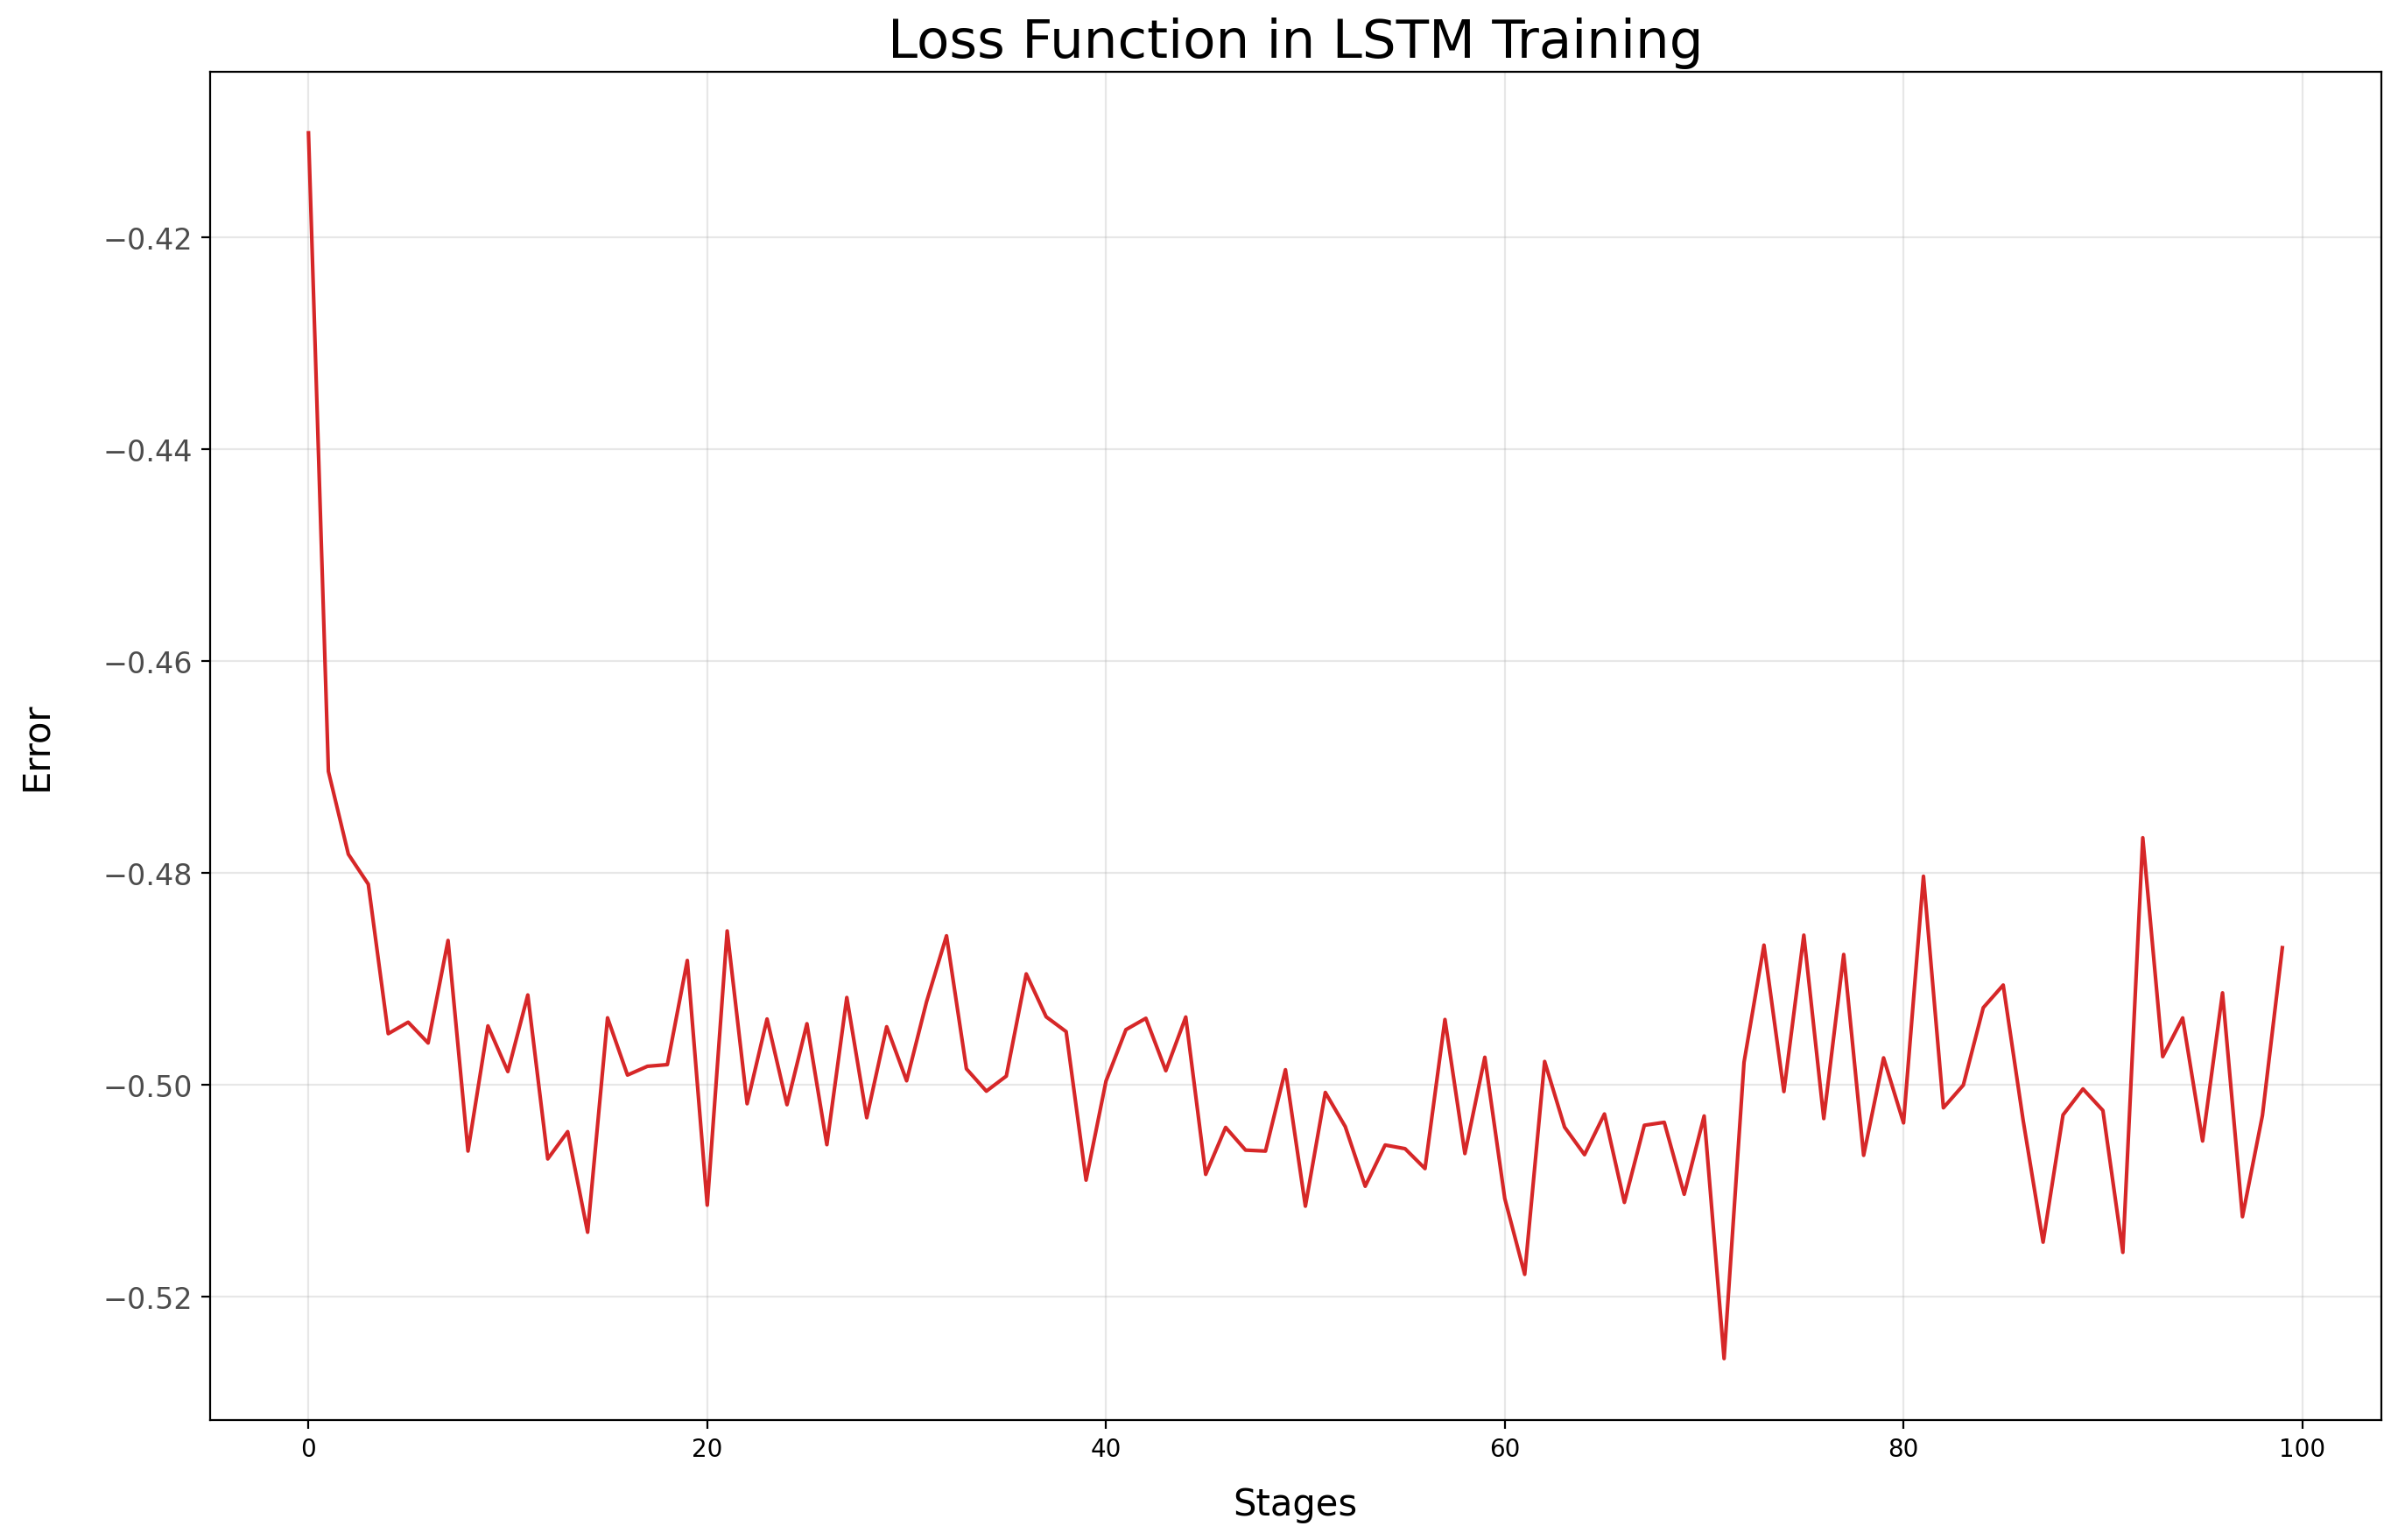

In [39]:
def visualize_loss(loss_arr):
  plt.figure(figsize=(16, 10), dpi=200)
  plt.plot(loss_arr[0,:], loss_arr[1,:], color="tab:red")

  plt.yticks(fontsize=12, alpha=.7)
  # plt.ylim(ymin=loss_arr[1,:].min(),ymax=np.quantile(loss_arr[1,:],0.95))
  plt.xlabel(r"Stages", fontsize=15, labelpad=10)
  plt.ylabel(r"Error", fontsize=15, labelpad=20)
  plt.title("Loss Function in LSTM Training", fontsize=22)
  plt.grid(axis='both', alpha=.3)

visualize_loss(loss_arr)

In [40]:
n_plot = 51
x_plot = np.linspace(xlow, xhigh, nplot)
t_plot = np.linspace(xlow, xhigh, nplot)

In [41]:
def mesh_values(x_plot, t_plot):
  u_value_mesh = np.zeros([n_plot, n_plot])
  for i in range(n_plot):
    for j in range(n_plot):
      u_value_mesh[i, j] = exact_solution(x_plot[j], t_plot[i])
  # fit
  x_mesh, t_mesh = np.meshgrid(x_plot, t_plot)
  x_plot2 = np.reshape(x_mesh, [n_plot**2,1])
  t_plot2 = np.reshape(t_mesh, [n_plot**2,1])
  fit_u_value = model(x_plot2, t_plot2)
  fit_u_value = np.squeeze(fit_u_value, axis=2)
  fit_u_value = tf.convert_to_tensor(np.sum(fit_u_value, axis=1).reshape(-1, 1))
  fit_u_value_mesh = np.reshape(fit_u_value, [n_plot, n_plot])

  return x_mesh, t_mesh, u_value_mesh, fit_u_value_mesh


def evaluate(u_value_mesh, fit_u_value_mesh):
  # accuracy check
  mean_abs_err = np.sum(np.abs(u_value_mesh - fit_u_value_mesh))/n_plot**2
  mean_sq_err = np.sum(np.abs(u_value_mesh - fit_u_value_mesh)**2)/n_plot**2
  r_sq = 1 - np.sum((u_value_mesh - fit_u_value_mesh)**2) / n_plot**2/np.var(u_value_mesh)

  return mean_abs_err, mean_sq_err, r_sq


In [42]:
x_mesh, t_mesh, u_value_mesh, fit_u_value_mesh = mesh_values(x_plot, t_plot)
evaluate(u_value_mesh, fit_u_value_mesh)

(0.00043263679190391253, 3.3145379704334233e-07, 0.999996265095075)

/var/folders/nw/8ph9ksx515nc537nnyyjj34w0000gn/T/ipykernel_60712/3249323544.py:13: RuntimeWarning: divide by zero encountered in divide
  np.abs(1 - np.divide(fit_u_value_mesh, u_value_mesh))),1.),


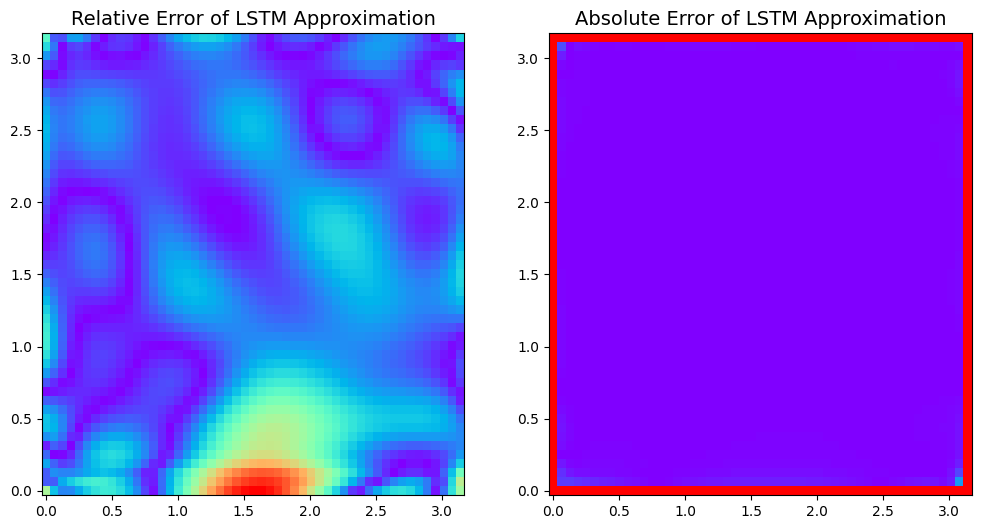

In [46]:
def visualize_error(x_mesh, t_mesh, u_value_mesh, fit_u_value_mesh):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  ax1.set_title("Relative Error of LSTM Approximation", fontsize=14)
  ax1.pcolormesh(
    t_mesh, x_mesh, np.abs(u_value_mesh - fit_u_value_mesh), 
    shading='auto', cmap = "rainbow"
  )

  ax2.set_title("Absolute Error of LSTM Approximation", fontsize=14)
  ax2.pcolormesh(
    t_mesh, x_mesh, np.minimum(np.where(u_value_mesh==0.,1., \
    np.abs(1 - np.divide(fit_u_value_mesh, u_value_mesh))),1.), 
    shading='auto', cmap = "rainbow"
  )

  plt.plot()


visualize_error(x_mesh, t_mesh, u_value_mesh, fit_u_value_mesh)


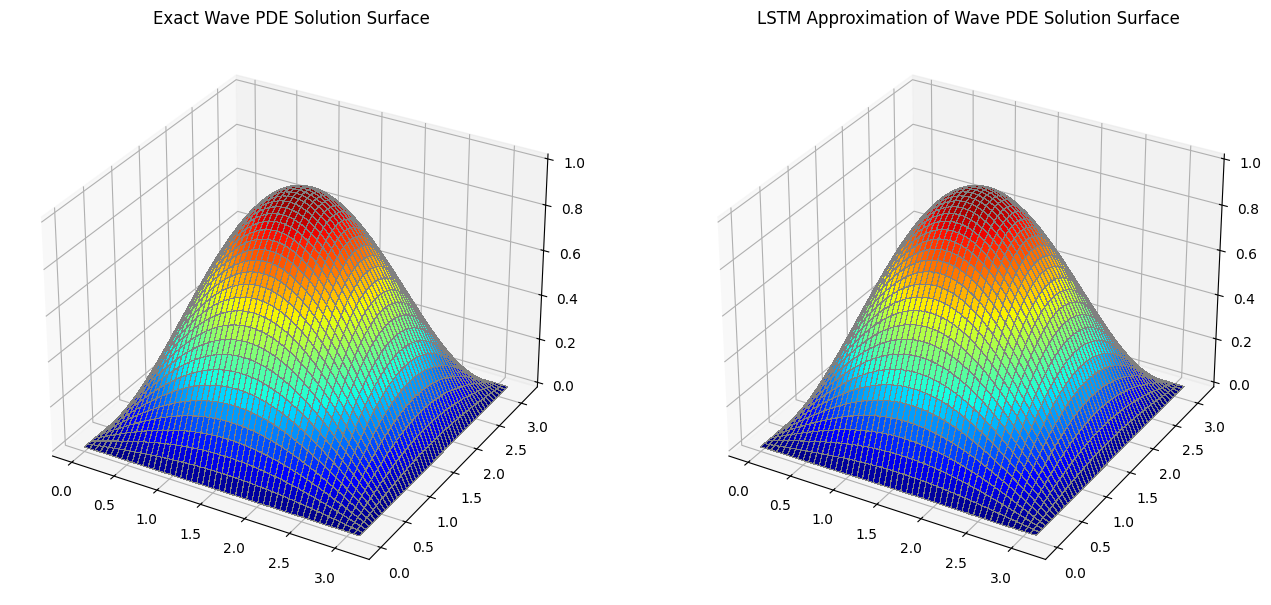

In [44]:
def visualize_solutions(x_mesh, t_mesh, u_value_mesh, fit_u_value_mesh):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={"projection": "3d"})

  ax1.set_title("Exact Wave PDE Solution Surface")
  ax1.plot_surface(
    t_mesh, x_mesh, u_value_mesh, rstride=1, cstride=1, linewidth=.05,
    cmap=cm.jet, antialiased=False, edgecolors='gray'
  )

  ax2.set_title("LSTM Approximation of Wave PDE Solution Surface")
  ax2.plot_surface(
    t_mesh, x_mesh, fit_u_value_mesh, rstride=1, cstride=1, linewidth=.05,
    cmap=cm.jet, antialiased=False, edgecolors='gray'
  )

visualize_solutions(x_mesh, t_mesh, u_value_mesh, fit_u_value_mesh)

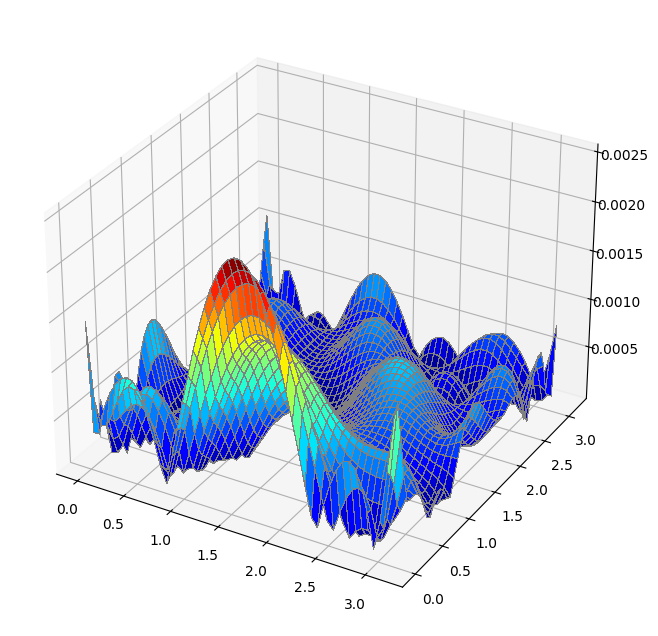

In [49]:
def visualize_error_3d(x_mesh, t_mesh, u_value_mesh, fit_u_value_mesh):
  figure = plt.figure(figsize=(8, 8))
  ax = figure.add_subplot(projection='3d')

  ax.plot_surface(
    t_mesh, x_mesh, np.abs(u_value_mesh - fit_u_value_mesh),
    rstride=1, cstride=1, linewidth=0.05, cmap=cm.jet, 
    antialiased=False, edgecolors='gray'
  )

visualize_error_3d(x_mesh, t_mesh, u_value_mesh, fit_u_value_mesh)